In [1]:
import csv
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import community as community_louvain
from networkx.algorithms.community import asyn_lpa_communities


# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
def read_data(filename):
    data = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)
    return data

In [3]:
def create_graph(data):
    G = nx.DiGraph()  # Initialize a directed graph

    # Add Nodes and Edges with initial attributes
    for row in data:
        players = ["striker", "non_striker", "bowler"]
        teams = ["batting_team", "bowling_team"]

        # Add Nodes
        for player in players:
            if row[player] and row[player] != 'NaN':
                G.add_node(row[player])

        for team in teams:
            if row[team] and row[team] != 'NaN':
                G.add_node(row[team])

        G.add_node(row['match_id'])

        # Add Edges and initialize weights
        if row["striker"] and row["batting_team"]:
            G.add_edge(row["striker"], row["batting_team"], weight=0)
        if row["non_striker"] and row["batting_team"]:
            G.add_edge(row["non_striker"], row["batting_team"], weight=0)
        if row["striker"] and row["bowling_team"]:
            G.add_edge(row["striker"], row["bowling_team"], weight=0)
        if row["non_striker"] and row["bowling_team"]:
            G.add_edge(row["non_striker"], row["bowling_team"], weight=0)
        if row["striker"] and row["non_striker"]:
            G.add_edge(row["striker"], row["non_striker"], weight=0)

        if row["striker"] and row["bowler"]:
            G.add_edge(row["striker"], row["bowler"],
                       Runs_Scored=0, Balls_Faced=0, Boundaries=0)
            G.add_edge(row["bowler"], row["striker"],
                       Balls_Bowled=0, Runs_Conceded=0, Wickets_Taken=0)

        if row["striker"]:
            G.add_edge(row["striker"], row["match_id"], weight=0)
        if row["non_striker"]:
            G.add_edge(row["non_striker"], row["match_id"], weight=0)
        if row["bowler"]:
            G.add_edge(row["bowler"], row["match_id"], weight=0)
        if row["batting_team"]:
            G.add_edge(row["batting_team"], row["match_id"], weight=0)
        if row["bowling_team"]:
            G.add_edge(row["bowling_team"], row["match_id"], weight=0)

    # Increment weights based on events
    for row in data:
        if row["striker"] and row["batting_team"]:
            G[row["striker"]][row["batting_team"]]['weight'] += 1
        if row["non_striker"] and row["batting_team"]:
            G[row["non_striker"]][row["batting_team"]]['weight'] += 1
        if row["striker"] and row["bowling_team"]:
            G[row["striker"]][row["bowling_team"]]['weight'] += 1
        if row["non_striker"] and row["bowling_team"]:
            G[row["non_striker"]][row["bowling_team"]]['weight'] += 1
        if row["striker"] and row["non_striker"]:
            G[row["striker"]][row["non_striker"]]['weight'] += 1

        if row["striker"] and row["bowler"]:
            G[row["striker"]][row["bowler"]]['Runs_Scored'] += int(row["runs_of_bat"])
            G[row["striker"]][row["bowler"]]['Balls_Faced'] += 1
            if int(row["runs_of_bat"]) >= 4:
                G[row["striker"]][row["bowler"]]['Boundaries'] += 1
            G[row["bowler"]][row["striker"]]['Balls_Bowled'] += 1
            G[row["bowler"]][row["striker"]]['Runs_Conceded'] += int(row["Runs_scored"])
            if row["wicket_type"] and row["player_dismissed"] == row["striker"]:
                G[row["bowler"]][row["striker"]]['Wickets_Taken'] += 1

        if row["striker"]:
            G[row["striker"]][row["match_id"]]['weight'] += 1
        if row["non_striker"]:
            G[row["non_striker"]][row["match_id"]]['weight'] += 1
        if row["bowler"]:
            G[row["bowler"]][row["match_id"]]['weight'] += 1
        if row["batting_team"]:
            G[row["batting_team"]][row["match_id"]]['weight'] += 1
        if row["bowling_team"]:
            G[row["bowling_team"]][row["match_id"]]['weight'] += 1

    return G

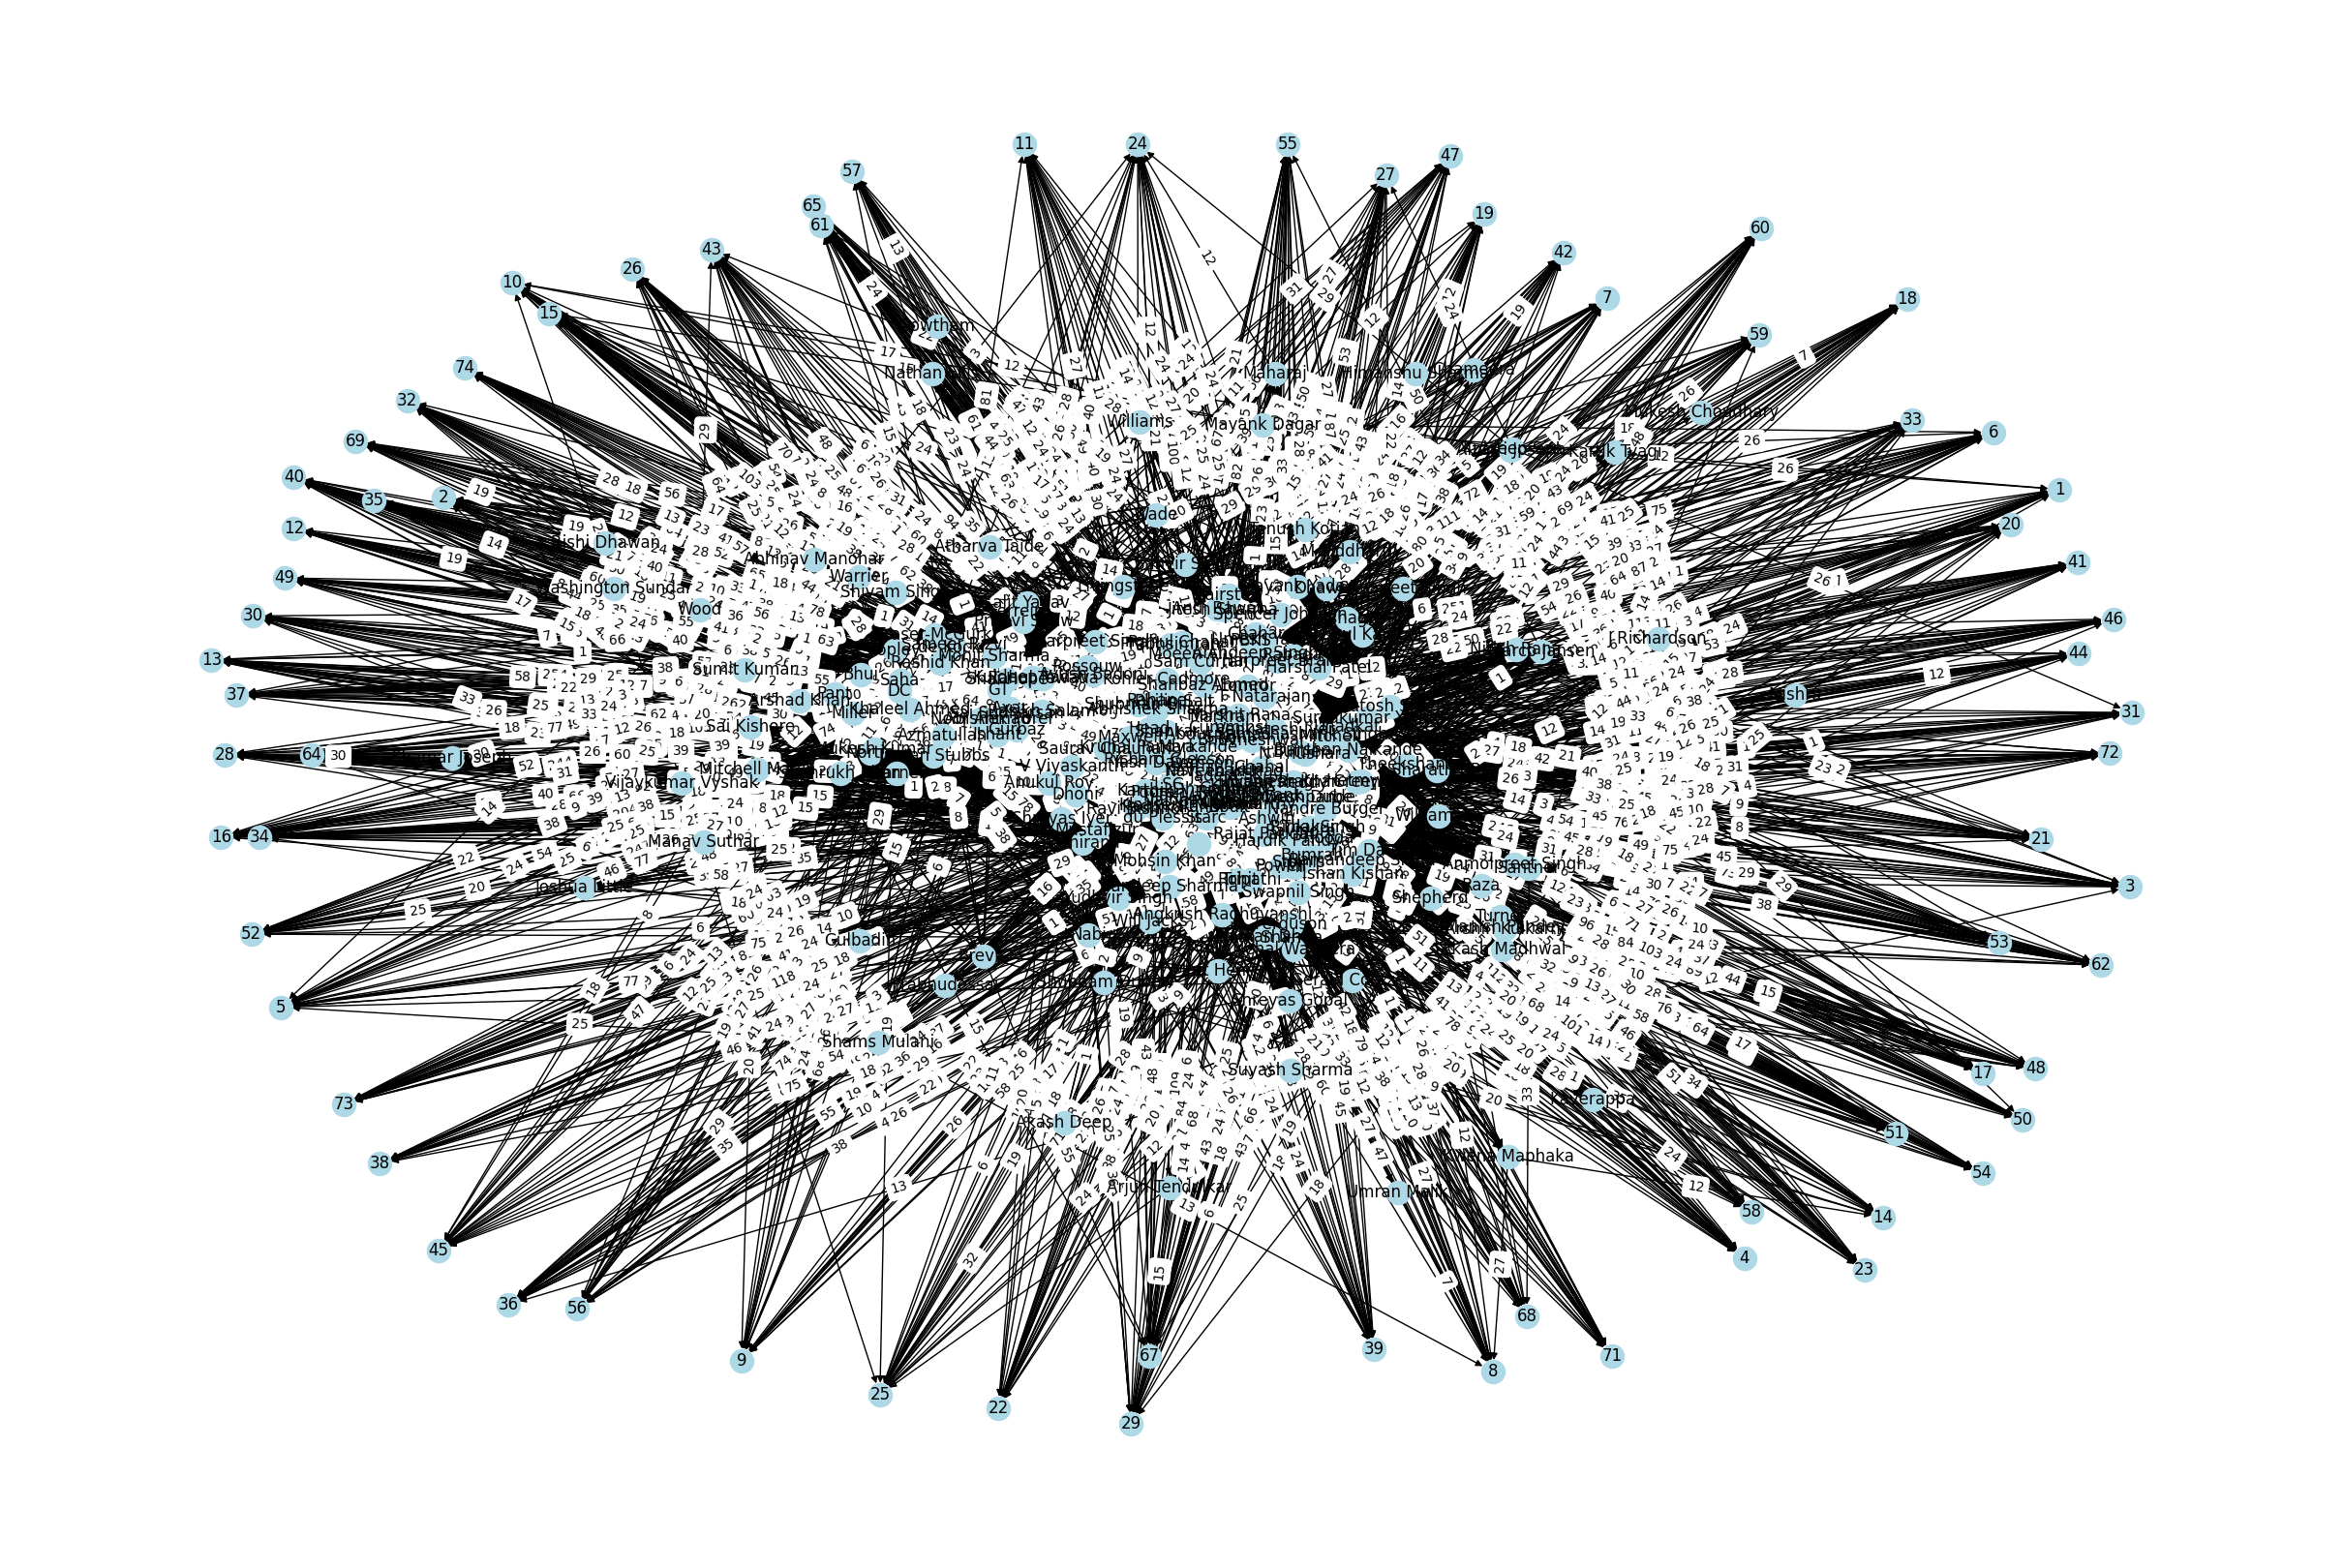

In [4]:
def visualize_graph(G):
    ## Use a layout algorithm (e.g., nx.spring_layout)
    pos = nx.spring_layout(G)

    # Choose a visualization library (e.g., matplotlib)
    plt.figure(figsize=(24, 16))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black')

    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.show()

data = read_data("ball_to_ball_data.csv")  # Replace with your file name
G = create_graph(data)
visualize_graph(G)

In [9]:
def calculate_centralities(G, nodes_of_interest):
    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)
    pagerank_centrality = nx.pagerank(G)
    harmonic_centrality = nx.harmonic_centrality(G)

    # Print centrality measures for specific nodes
    for node in nodes_of_interest:
        print(f"Centralities for {node}:")
        print(f"  Degree Centrality: {degree_centrality.get(node, 0)}")
        print(f"  Betweenness Centrality: {betweenness_centrality.get(node, 0)}")
        print(f"  Closeness Centrality: {closeness_centrality.get(node, 0)}")
        print(f"  Eigenvector Centrality: {eigenvector_centrality.get(node, 0)}")
        print(f"  PageRank Centrality: {pagerank_centrality.get(node, 0)}")
        print(f"  Harmonic Centrality: {harmonic_centrality.get(node, 0)}")
        print("\n")

In [10]:
#Call the function with nodes of interest
nodes_of_interest = ['Kohli','Klaasen','Abhishek Sharma']
calculate_centralities(G, nodes_of_interest)

Centralities for Kohli:
  Degree Centrality: 0.5086505190311419
  Betweenness Centrality: 0.00972232700839529
  Closeness Centrality: 0.4141520558272603
  Eigenvector Centrality: 0.08839580108632289
  PageRank Centrality: 0.002978179562656026
  Harmonic Centrality: 132.83333333333334


Centralities for Klaasen:
  Degree Centrality: 0.4290657439446367
  Betweenness Centrality: 0.005147324299353475
  Closeness Centrality: 0.3964343208186074
  Eigenvector Centrality: 0.07756684079596195
  PageRank Centrality: 0.002453802105118365
  Harmonic Centrality: 126.83333333333329


Centralities for Abhishek Sharma:
  Degree Centrality: 0.4948096885813149
  Betweenness Centrality: 0.01830455167909931
  Closeness Centrality: 0.41299842893080546
  Eigenvector Centrality: 0.08160191674907959
  PageRank Centrality: 0.0028042793828075034
  Harmonic Centrality: 132.33333333333334




In [11]:
#Call the function with nodes of interest
nodes_of_interest = ['RCB','MI','SRH']
calculate_centralities(G, nodes_of_interest)

Centralities for RCB:
  Degree Centrality: 0.40484429065743943
  Betweenness Centrality: 0.003059213095936757
  Closeness Centrality: 0.47675930619531437
  Eigenvector Centrality: 0.14181434671775459
  PageRank Centrality: 0.01454777018485469
  Harmonic Centrality: 155.0


Centralities for MI:
  Degree Centrality: 0.40484429065743943
  Betweenness Centrality: 0.0032222483261963703
  Closeness Centrality: 0.4782824988668649
  Eigenvector Centrality: 0.12917228243395415
  PageRank Centrality: 0.01499222481561969
  Harmonic Centrality: 155.5


Centralities for SRH:
  Degree Centrality: 0.39100346020761245
  Betweenness Centrality: 0.0031525648137534575
  Closeness Centrality: 0.4708577218682965
  Eigenvector Centrality: 0.1269888495718531
  PageRank Centrality: 0.016213937458736054
  Harmonic Centrality: 153.0




In [12]:
#Call the function with nodes of interest
nodes_of_interest = ['Shubman Gill','KKR','Bumrah']
calculate_centralities(G, nodes_of_interest)

Centralities for Shubman Gill:
  Degree Centrality: 0.411764705882353
  Betweenness Centrality: 0.008690226659087167
  Closeness Centrality: 0.38510762593807574
  Eigenvector Centrality: 0.06247002496628193
  PageRank Centrality: 0.003014770437832102
  Harmonic Centrality: 124.66666666666659


Centralities for KKR:
  Degree Centrality: 0.40484429065743943
  Betweenness Centrality: 0.002840744253993481
  Closeness Centrality: 0.47830800227760495
  Eigenvector Centrality: 0.13302101678511305
  PageRank Centrality: 0.014995509616428327
  Harmonic Centrality: 155.83333333333331


Centralities for Bumrah:
  Degree Centrality: 0.5397923875432526
  Betweenness Centrality: 0.013027860933654123
  Closeness Centrality: 0.42605297697172173
  Eigenvector Centrality: 0.09053276270394695
  PageRank Centrality: 0.002074473695166597
  Harmonic Centrality: 137.5




In [24]:


# Convert your graph to an undirected graph if not already done
undirected_G = G.to_undirected()

# Apply Louvain community detection
partition = community_louvain.best_partition(undirected_G, weight='weight')

# Organize the communities based on partition
team_clusters = {}
for player, community_id in partition.items():
    if community_id not in team_clusters:
        team_clusters[community_id] = []
    team_clusters[community_id].append(player)

# Display the communities
print("Team Clusters:", team_clusters)


Team Clusters: {3: ['Kohli', 'du Plessis', 'RCB', 'Rajat Patidar', 'Maxwell', 'Green', 'Anuj Rawat', 'Karthik', 'Siraj', 'Yash Dayal', 'Karn Sharma', 'Lomror', 'Saurav Chauhan', '25', 'Will Jacks', 'Shreyas Gopal', 'Akash Deep', 'Ferguson', '41', 'Swapnil Singh', 'Kaverappa', '58', '62', '68', '72'], 4: ['Chahar', 'CSK', '1', 'Tushar Deshpande', 'Theekshana', 'Mustafizur', 'Jadeja', 'Gaikwad', 'Ravindra', 'Rahane', 'Mitchell', 'Shivam Dube', ' ', 'Sameer Rizvi', 'Pathirana', '13', 'Dhoni', '18', 'Mukesh Choudhary', 'Moeen Ali', 'Thakur', '29', 'Matt Henry', '34', '39', '46'], 9: ['Alzarri Joseph', 'Mayank Dagar', 'Sam Curran', 'PBKS', 'Arshdeep Singh', 'Rabada', 'Harpreet Brar', 'Rahul Chahar', 'Harshal Patel', 'Dhawan', 'Bairstow', 'Prabhsimran', 'Jitesh Sharma', 'Livingstone', 'Shashank Singh', '6', 'Raza', 'Ashutosh Sharma', '23', 'Maharaj', 'Atharva Taide', '27', 'Tanush Kotian', 'Rossouw', 'Harpreet Singh', '37', '42', 'Chameera', '49', 'Richard Gleeson', '53', 'Santner', 'Ferreir

In [22]:
# Apply the Label Propagation Algorithm
player_groups = list(asyn_lpa_communities(G, weight='weight'))

# Display the communities
print("Player Groups:", player_groups)


Player Groups: [{'Swapnil Singh', 'Klaasen', 'Abdul Samad', 'Will Jacks', 'Prabhudessai', 'Head', 'RCB', 'SRH', 'Maxwell', 'Vijaykumar Vyshak', 'Kohli', 'Green', 'Unadkat', 'Shahbaz Ahmed', 'Topley', '30', 'Sanvir Singh', 'Bhuvneshwar', 'T Natarajan', 'Anuj Rawat', 'Rajat Patidar', ' ', 'Ferguson', 'Cummins', 'Saurav Chauhan', 'du Plessis', 'Markande', 'Abhishek Sharma', 'Karn Sharma', 'Mayank', 'Yash Dayal', 'Karthik', 'Tripathi', 'Lomror', 'Nitish Reddy', 'Markram'}, {'Sharath BR', 'Azmatullah', 'Mohit Sharma', 'Spencer Johnson', 'Umesh Yadav', 'Sai Kishore', 'Miller', 'Abhinav Manohar', 'Shahrukh Khan', 'Wade', 'Mustafizur', '7', 'Noor Ahmad', 'Shubman Gill', 'Shankar', 'Rashid Khan', 'Saha', 'Pathirana', 'Rahul Tewatia', 'Sai Sudharsan', 'Williamson', 'GT', 'Chahar'}, {'Thakur', 'Tristan Stubbs', 'Mitchell Marsh', 'Lalit Yadav', 'Bhui', 'Kuldeep Yadav', 'Sameer Rizvi', 'Mukesh Kumar', 'CSK', 'Rahane', 'Jadeja', 'Kushagra', 'Nortje', 'Pant', 'Axar', 'Fraser-McGurk', 'Shai Hope', 'Kh

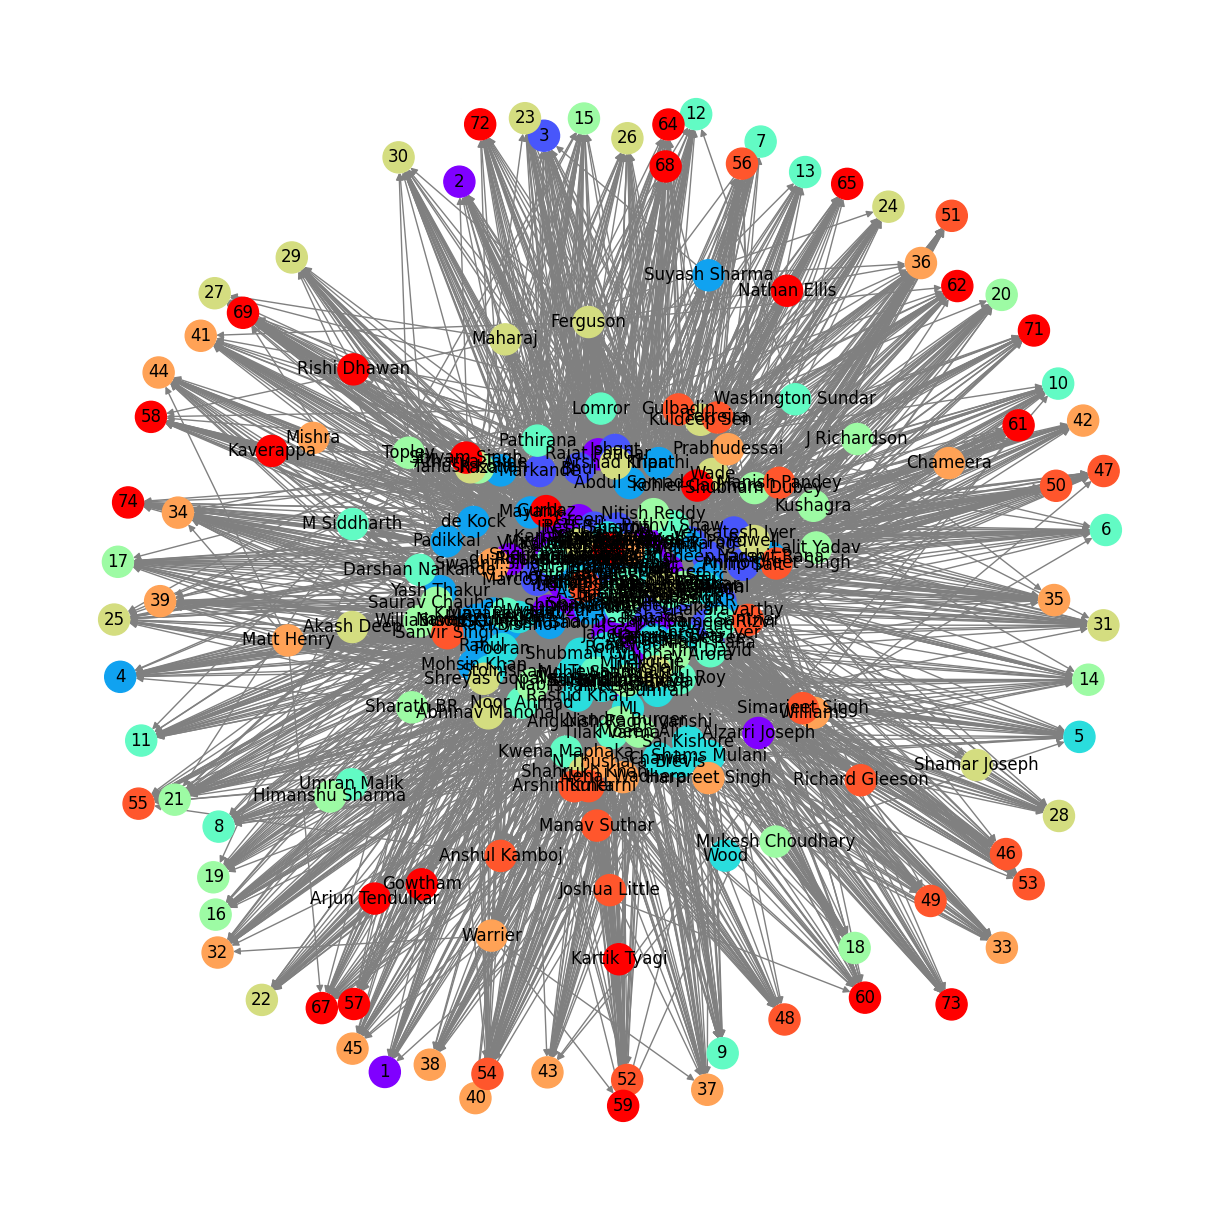

In [19]:

# Assuming communities is a list of lists, where each sublist contains nodes in one community
pos = nx.spring_layout(G)  # Layout for visualization
colors = [i for i in range(len(communities)) for _ in communities[i]]  # Assign colors to each community

plt.figure(figsize=(12, 12))
nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow, node_size=500, edge_color='gray')
plt.show()

